## Connecting to the drive to access the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary libraries

In [ ]:
import warnings
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from PIL import ImageEnhance
import cv2

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
import zipfile

# Unzipping the images
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/AI_project/images.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/AI_project/")
# zip_ref.close()

## Getting the paths to the Data folders

In [ ]:
import os

# The path to the images folder on google drive
path = '/content/drive/MyDrive/AI_project/eye-images'

normal = os.path.join(path,'1_normal/')
cataract = os.path.join(path,'2_cataract/')
glaucoma = os.path.join(path,'2_glaucoma/')
print("Number of Normal eye dataset", len(os.listdir(normal)))
print("Number of Cataract dataset", len(os.listdir(cataract)))
print("Number of Glaucoma dataset", len(os.listdir(glaucoma)))


Number of Normal eye dataset 300
Number of Cataract dataset 100
Number of Glaucoma dataset 101


In [ ]:
## Load the file names from all directories
normal_images = os.listdir(normal)
cataract_images =  os.listdir(cataract)
glaucoma_images =  os.listdir(glaucoma)

## Quality Control

Since the quality control was already performed in the initial part of the project while implementing the custom CNN, the steps were not repeated for this part.

## Pre-processing the Images for the model

In [ ]:
import cv2  # used to read images

def load_images(directories, n_images=900000):
    """
    Reads in images and assigns class labels
    Parameters:
        directories: A list of the sub-directories
        n_images:    The maximum number of images to load from each directory
    Returns:
        images (numpy.ndarray) : Image data
        label (numpy.ndarray      : Labels of each image
    """
    images = []
    labels = []
    for label, sub_dir in enumerate(directories):
        num=1
        for file_name in os.listdir(sub_dir):
            if num > n_images:
                break
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize to a smaller, consistent shape
                #gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #images.append(gray_image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                num+=1
    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images([normal, cataract, glaucoma])

In [ ]:
images.shape

(501, 224, 224, 3)

### Splitting the dataset for the model

In [ ]:
# Import required package
from sklearn.model_selection import train_test_split

# Spliting data into training + validation and test set (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Further spliting training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42
)

# Convert labels to categorical for training, validation, and test sets
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (320, 224, 224, 3)
y_train shape: (320,)


In [ ]:
from collections import Counter

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 190, 1: 67, 2: 63})
Counter({0: 53, 2: 28, 1: 20})


## Data Augmentation

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, GaussianNoise, Rescaling, Resizing

data_augmentation = Sequential([

    Input(shape=(224, 224, 3)),
    RandomFlip("horizontal"),  # horizontal flips for anatomical realism
    RandomBrightness(factor=0.1),
    RandomRotation((-0.025, 0.025)),  # Small rotations to simulate slight capture variations
    RandomZoom(0.05),  # Minor zoom variations
    RandomTranslation(0.025, 0.025),  # Handle slight misalignments
    GaussianNoise(0.05),  # Add subtle noise for robustness
    Rescaling(1./255)  # Normalize pixel values to [0, 1]
])


In [ ]:
data_augmentation.summary()

### Computing class weights to account for the class imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Compute class weights based on your training labels
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Step 2: Convert class weights to a dictionary (class_index: weight)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

print(class_weights)

{0: 0.5614035087719298, 1: 1.592039800995025, 2: 1.693121693121693}


# Transfer Learning using Pre-Trained Models

### Using ResNet50 - a model trained on millions of images

In [ ]:
from tensorflow.keras.applications import ResNet50

# Loading the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
base_model.summary()

In [ ]:
#Freezing the base model
base_model.trainable = False

# Building the new model with data augmentation
model_tl = models.Sequential([
    Input(shape=(224, 224, 3)),
    base_model,  # Pre-trained ResNet50
    layers.GlobalAveragePooling2D(),  # Reduces spatial dimensions
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')  # Output for 3 classes
])

In [ ]:
# Compiling the model
model_tl.compile(
    optimizer=Adam(learning_rate=1e-4),  # Small learning rate for fine-tuning
    loss='categorical_crossentropy',  # Multi-class classification
    metrics=['accuracy','categorical_accuracy']
)

model_tl.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,719,043 (90.48 MB)

 Trainable params: 131,331 (513.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model with class weights
history = model_tl.fit(
    X_train,  # Training data
    y_train_cat,  # One-hot encoded labels
    validation_data=(X_val, y_val_cat),  # Validation data
    epochs=100,  # Number of epochs
    batch_size=32,  # Batch size
    class_weight=class_weights  # Class weights to handle class imbalance
    #callbacks=[early_stopping]  # Early stopping callback
)

## Functions to visualise the model performance

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_loss(epochs, loss_values, val_loss_values, title='Training and Validation Loss'):
    """
    Plots the training and validation loss over epochs.

    Args:
        epochs: List or array of epoch values.
        loss_values: List or array of training loss values.
        val_loss_values: List or array of validation loss values.
        title: The title of the plot.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_values, 'b', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, accuracy_values, val_accuracy_values, title='Training and Validation Accuracy'):
    """
    Plots the training and validation accuracy over epochs.

    Args:
        epochs: List or array of epoch values.
        accuracy_values: List or array of training accuracy values.
        val_accuracy_values: List or array of validation accuracy values.
        title: The title of the plot.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', cmap='viridis'):
    """
    Plots the confusion matrix.

    Args:
        y_true: The true labels.
        y_pred: The predicted labels.
        title: Title of the plot.
        cmap: Color map for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

    fig, ax = plt.subplots(figsize=(5, 5))
    cmdisp.plot(include_values=True, cmap=cmap, ax=ax, xticks_rotation="vertical")
    plt.title(title)
    plt.show()


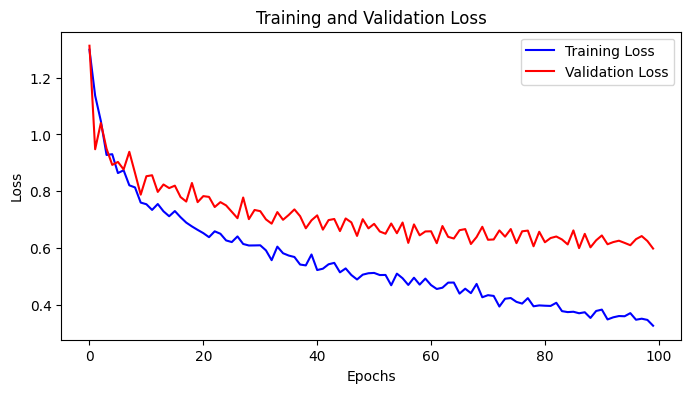

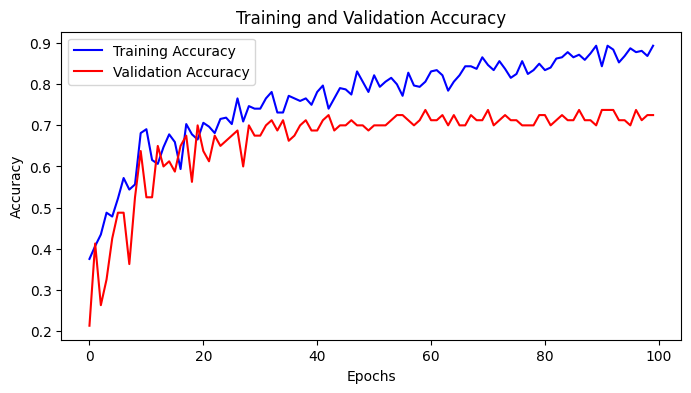

In [ ]:
epochs = history.epoch
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# Plot training and validation loss
plot_loss(epochs, loss_values, val_loss_values)

# Plot training and validation accuracy
plot_accuracy(epochs, accuracy_values, val_accuracy_values)


The model overfits with training accuracy higher than validation accuracy. Also, the validation accuracy stabilises at ~70% after ~50 epochs though the traning performance continues to improve.

In [ ]:
y_pred_prob = model_tl.predict(X_test)
y_pred  = y_pred_prob.argmax(axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


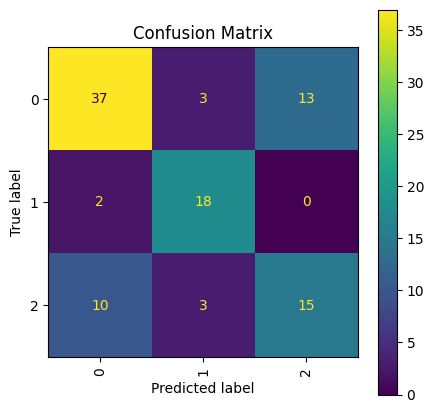

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        53
           1       0.75      0.90      0.82        20
           2       0.54      0.54      0.54        28

    accuracy                           0.69       101
   macro avg       0.68      0.71      0.69       101
weighted avg       0.69      0.69      0.69       101



The performance remains poor for Glaucoma (poorer than the custom CNN model). However, the performance on cataract and normal remains comparable to the custom CNN model.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(y_test_cat, y_pred_prob, n_classes, figsize=(10, 8)):
    """
    Plots a multi-class ROC curve with AUC for each class.

    Parameters:
    - y_test_cat: numpy array or tensor, one-hot encoded true labels.
    - y_pred_prob: numpy array or tensor, predicted probabilities for each class.
    - n_classes: int, number of classes.
    - figsize: tuple, figure size for the plot.
    """
    plt.figure(figsize=figsize)

    # Loop through each class to compute and plot the ROC curve
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Plot the "chance" line
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')

    # Add labels, title, and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


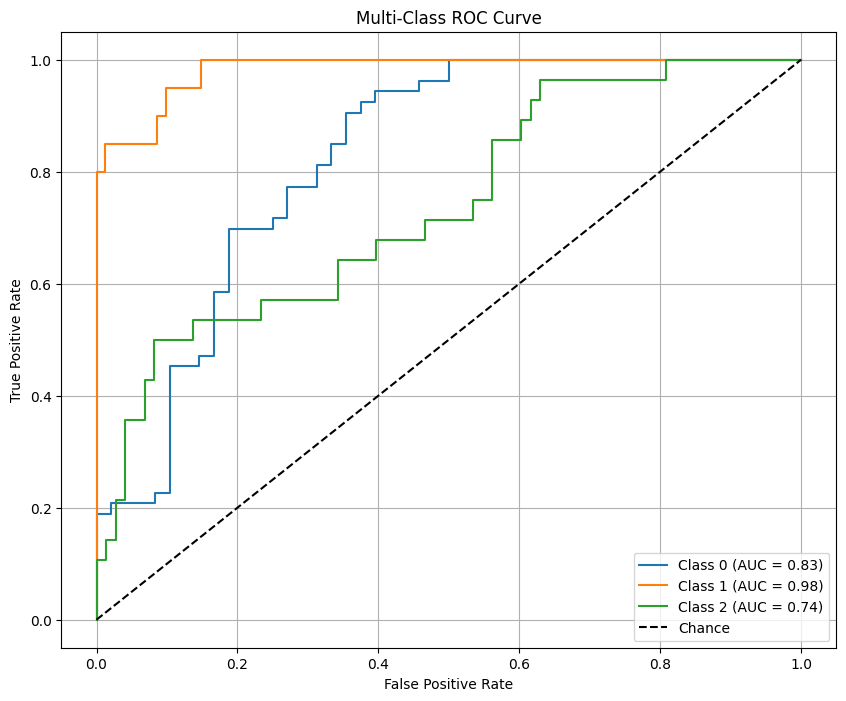

In [ ]:
plot_multiclass_roc(y_test_cat, y_pred_prob,3)

### Increasing the weightage for Glaucoma to improve performance

In [ ]:
class_weights2 = {0:0.65, 1:1.56, 2:1.85}

In [ ]:
# Compiling the model
model_tl.compile(
    optimizer=Adam(learning_rate=1e-4),  # Small learning rate for fine-tuning
    loss='categorical_crossentropy',  # Multi-class classification
    metrics=['accuracy','categorical_accuracy']
)
model_tl.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,719,043 (90.48 MB)

 Trainable params: 131,331 (513.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Training the model with class weights
history2 = model_tl.fit(
    X_train,  # Training data
    y_train_cat,  # One-hot encoded labels
    validation_data=(X_val, y_val_cat),  # Validation data
    epochs=60,  # Number of epochs
    batch_size=32,  # Batch size
    class_weight=class_weights2  # Class weights to handle class imbalance
    #callbacks=[early_stopping]  # Early stopping callback
)

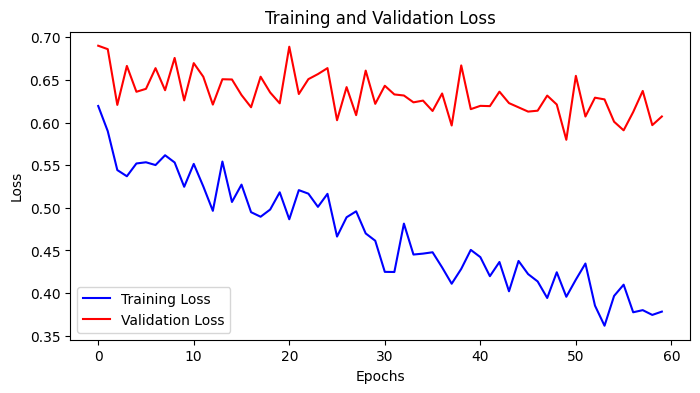

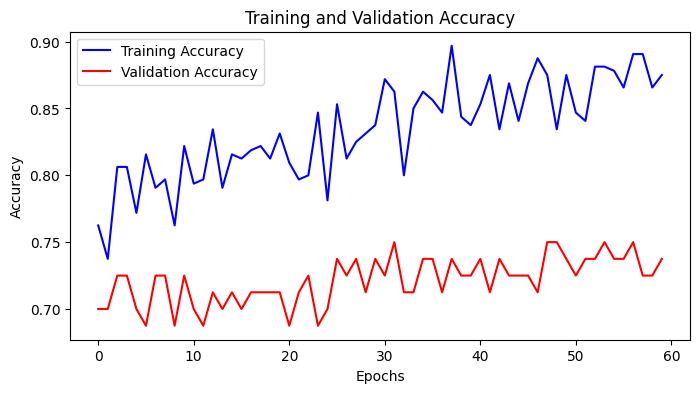

In [ ]:
epochs = history2.epoch
loss_values = history2.history['loss']
val_loss_values = history2.history['val_loss']
accuracy_values = history2.history['accuracy']
val_accuracy_values = history2.history['val_accuracy']

# Plot training and validation loss
plot_loss(epochs, loss_values, val_loss_values)

# Plot training and validation accuracy
plot_accuracy(epochs, accuracy_values, val_accuracy_values)

In [ ]:
y_pred_prob = model_tl.predict(X_test)
y_pred  = y_pred_prob.argmax(axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


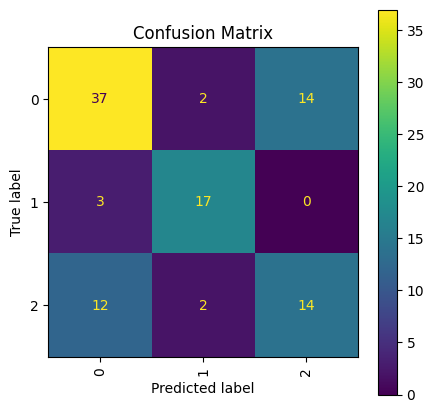

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        53
           1       0.81      0.85      0.83        20
           2       0.50      0.50      0.50        28

    accuracy                           0.67       101
   macro avg       0.67      0.68      0.68       101
weighted avg       0.67      0.67      0.67       101



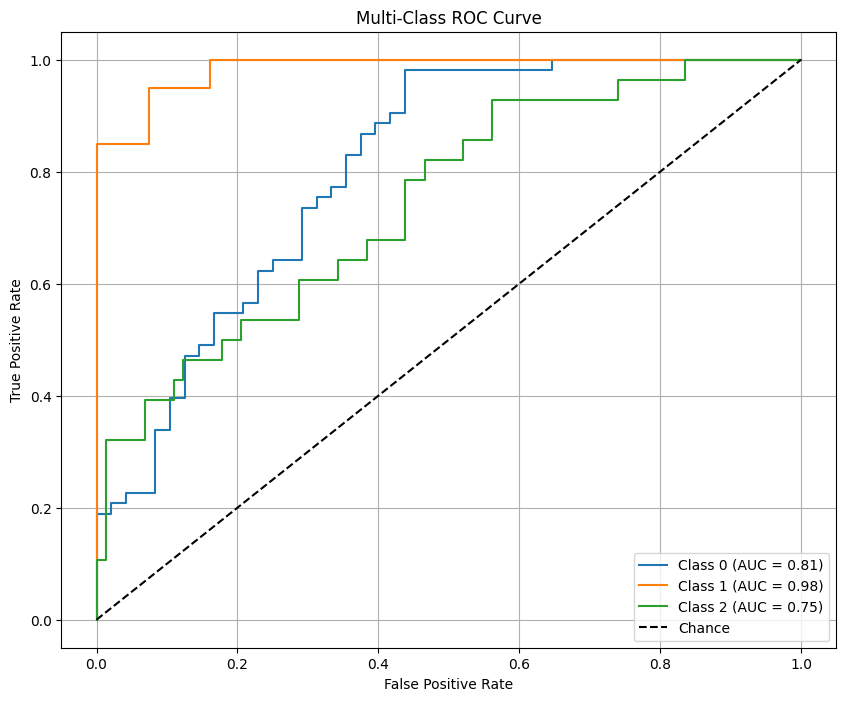

In [ ]:
plot_multiclass_roc(y_test_cat, y_pred_prob,3)

## Fine Tuning the model by training the last few layers of ResNet50

In [ ]:
# Fine-tuning the base model to improve the performance
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompiling the model after unfreezing some layers
model_tl.compile(
    optimizer=Adam(learning_rate=1e-5),  # Smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', 'categorical_accuracy']
)
model_tl.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,719,043 (90.48 MB)

 Trainable params: 4,596,995 (17.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [ ]:
# Training (fine-tuning) with class weights
history_finetune = model_tl.fit(
    X_train,  # Training data
    y_train_cat,  # One-hot encoded labels
    validation_data=(X_val, y_val_cat),  # Validation data
    epochs=50,  # Fine-tuning for additional epochs
    batch_size=32,  # Batch size
    class_weight=class_weights2,  # Class weights to handle class imbalance
    verbose=1
)

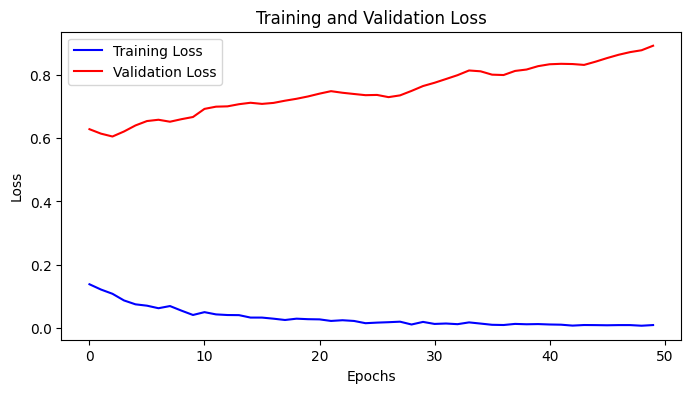

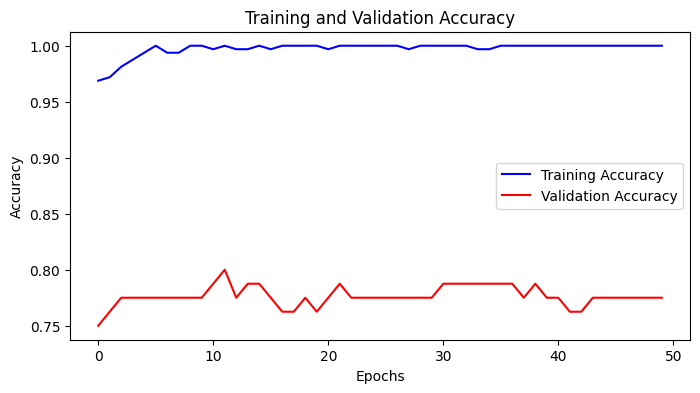

In [ ]:
epochs = history_finetune.epoch
loss_values = history_finetune.history['loss']
val_loss_values = history_finetune.history['val_loss']
accuracy_values = history_finetune.history['accuracy']
val_accuracy_values = history_finetune.history['val_accuracy']

# Plot training and validation loss
plot_loss(epochs, loss_values, val_loss_values)

# Plot training and validation accuracy
plot_accuracy(epochs, accuracy_values, val_accuracy_values)

In [ ]:
y_pred_prob = model_tl.predict(X_test)
y_pred  = y_pred_prob.argmax(axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


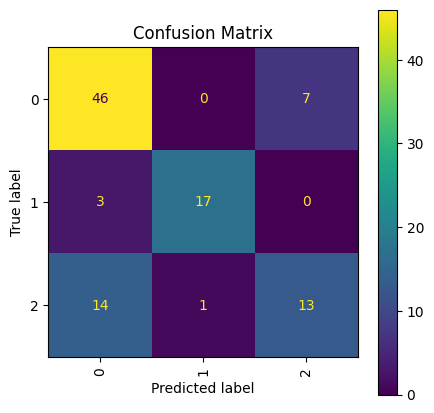

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        53
           1       0.94      0.85      0.89        20
           2       0.65      0.46      0.54        28

    accuracy                           0.75       101
   macro avg       0.77      0.73      0.74       101
weighted avg       0.75      0.75      0.74       101



# Testing Inception V3 transfer Learning model (Kermany et al., 2018)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np


In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_inc = models.Sequential([
    data_augmentation,
    base_model,  # Pre-trained InceptionV3
    layers.GlobalAveragePooling2D(),  # Reduce spatial dimensions
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to avoid overfitting
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes
])
# Compile the model
model_inc.compile(
    optimizer=Adam(learning_rate=1e-4),  # Small learning rate for fine-tuning
    loss='categorical_crossentropy',  # Multi-class classification
    metrics=['accuracy']
)

model_inc.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:

history_inc = model_inc.fit(
    X_train,  # Training data
    y_train_cat,  # One-hot encoded labels
    validation_data=(X_val, y_val_cat),  # Validation data
    epochs=50,  # Fine-tuning for additional epochs
    batch_size=32,  # Batch size
    class_weight=class_weights,  # Class weights to handle class imbalance
    verbose=1
)

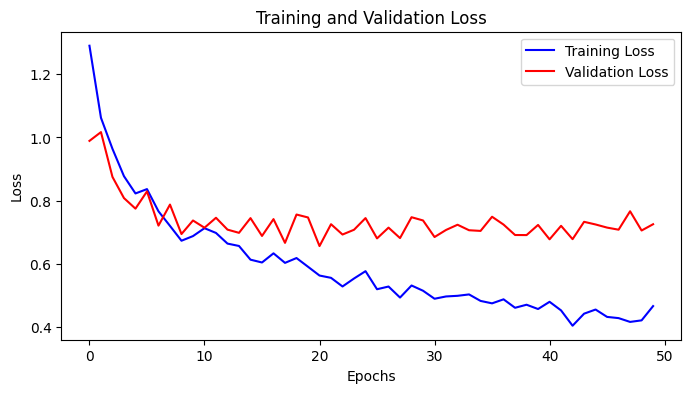

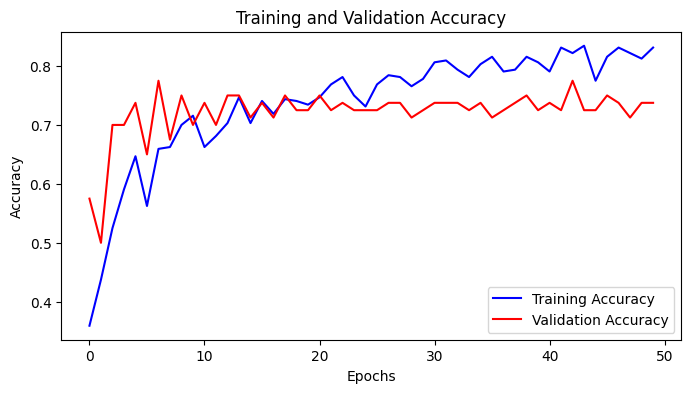

In [ ]:
epochs = history_inc.epoch
loss_values = history_inc.history['loss']
val_loss_values = history_inc.history['val_loss']
accuracy_values = history_inc.history['accuracy']
val_accuracy_values = history_inc.history['val_accuracy']

# Plot training and validation loss
plot_loss(epochs, loss_values, val_loss_values)

# Plot training and validation accuracy
plot_accuracy(epochs, accuracy_values, val_accuracy_values)

In [ ]:
y_pred_prob = model_inc.predict(X_test)
y_pred  = y_pred_prob.argmax(axis=1)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


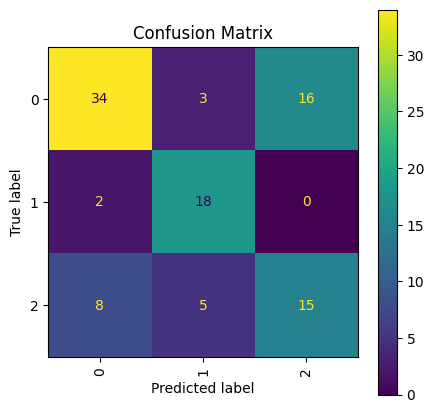

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70        53
           1       0.69      0.90      0.78        20
           2       0.48      0.54      0.51        28

    accuracy                           0.66       101
   macro avg       0.65      0.69      0.66       101
weighted avg       0.68      0.66      0.66       101



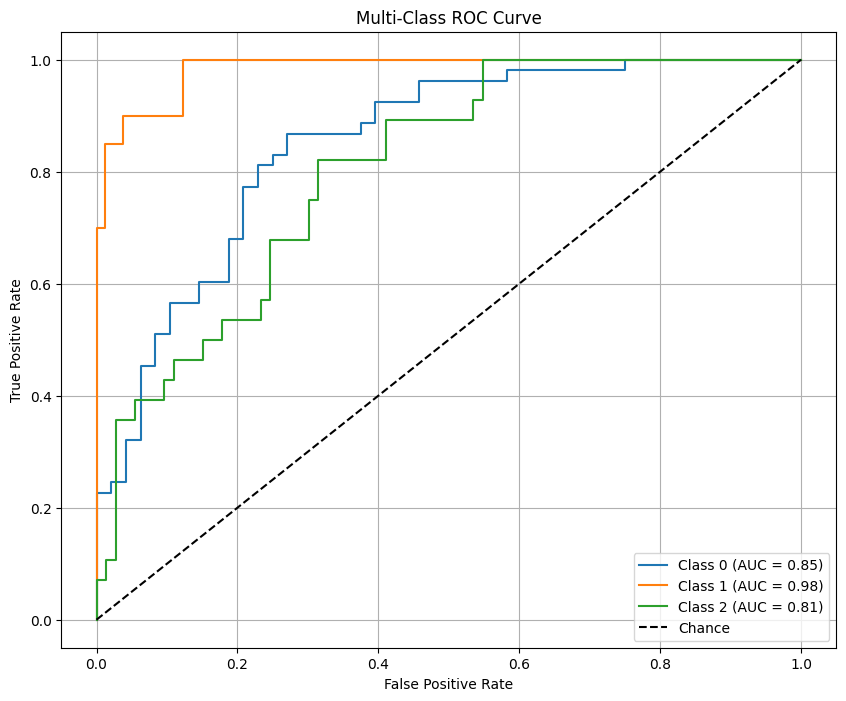

In [ ]:
plot_multiclass_roc(y_test_cat, y_pred_prob,3)

## DenseNet121 for Transfer Learning (Ghadah Alwakid et al., 2023)

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load the InceptionV3 model pre-trained on ImageNet
base_model_DN121 = DenseNet121(weights='imagenet',
                               include_top=False,
                               input_shape=(224, 224, 3))

# Freeze the base model layers
base_model_DN121.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_dn = models.Sequential([
    data_augmentation,
    base_model_DN121,  # Pre-trained InceptionV3
    Flatten(),  # Reduce spatial dimensions
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to avoid overfitting
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes
])
# Compile the model
model_dn.compile(
    optimizer=Adam(learning_rate=1e-4),  # Small learning rate for fine-tuning
    loss='categorical_crossentropy',  # Multi-class classification
    metrics=['accuracy','categorical_accuracy']
)

model_dn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,460,547 (51.35 MB)

 Trainable params: 6,423,043 (24.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history_dn = model_dn.fit(
    X_train,  # Training data
    y_train_cat,  # One-hot encoded labels
    validation_data=(X_val, y_val_cat),  # Validation data
    epochs=50,  # Fine-tuning for additional epochs
    batch_size=32,  # Batch size
    class_weight=class_weights,  # Class weights to handle class imbalance
    verbose=1
)

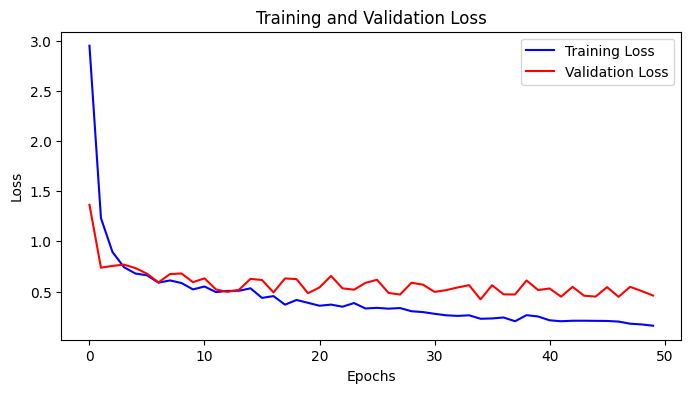

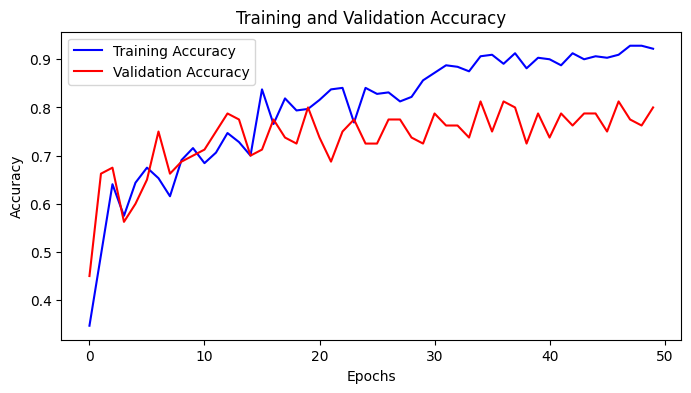

In [ ]:
epochs = history_dn.epoch
loss_values = history_dn.history['loss']
val_loss_values = history_dn.history['val_loss']
accuracy_values = history_dn.history['accuracy']
val_accuracy_values = history_dn.history['val_accuracy']

# Plot training and validation loss
plot_loss(epochs, loss_values, val_loss_values)

# Plot training and validation accuracy
plot_accuracy(epochs, accuracy_values, val_accuracy_values)

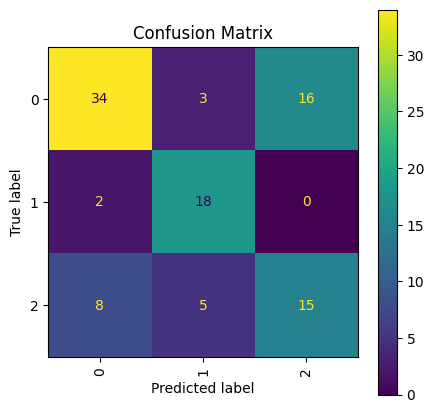

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70        53
           1       0.69      0.90      0.78        20
           2       0.48      0.54      0.51        28

    accuracy                           0.66       101
   macro avg       0.65      0.69      0.66       101
weighted avg       0.68      0.66      0.66       101



In [ ]:
!apt-get update
!apt-get install -y pandoc
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [6]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/AI_project/TransferLearning.ipynb --allow-chromium-download

[NbConvertApp] Converting notebook /content/drive/MyDrive/AI_project/TransferLearning.ipynb to pdf
[NbConvertApp] Support files will be in TransferLearning_files/
[NbConvertApp] Making directory ./TransferLearning_files
[NbConvertApp] Writing 114755 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 637474 bytes to /content/drive/MyDrive/AI_project/TransferLearning.pdf
